In [1]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm

In [2]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

# data_cutoff_date = '20230508'
data_cutoff_date = '20230619'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet"
# slope relative local earth coodinates
sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_planar_fit.parquet"
# seemingly local earth coodinates
# sos_tidy_fn = f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

In [3]:
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit_multiplane.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_planar_fit.parquet")))
print(len(pd.read_parquet(f"tidy_df_{start_date}_{end_date}_noplanar_fit.parquet")))

9591120
9568944
9591120


# Open data

## SOS

In [4]:
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df.set_index('time').sort_index().loc[start_date:data_cutoff_date].reset_index()

## SPLASH

In [5]:

# Get the list of files in the directory
file_list = os.listdir(kps_download_dir)

file_list = [f for f in file_list if 'sledmet.asfs30.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
mixingratio_dataarray_list = []

abshum_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(kps_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    abshum_dataarray_list.append(dataset['h2o_licor'])

mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')

100%|██████████| 646/646 [00:32<00:00, 19.85it/s]


## Calibrate SOS gas analyzer measurements

We calibrate by assuming that all gas analyzers have the same seasonal mean as the corresponding hygrometer measurement on the central tower (at a given height)

### With seasonal mean

In [6]:
hygrometer_absolute_humidity_mean = (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
).reset_index().query("tower == 'c'")

In [7]:
ec_absolute_humidity_mean = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()

In [8]:
corrections_df = ec_absolute_humidity_mean.merge(
    hygrometer_absolute_humidity_mean[['height', 'value']].rename(columns={'value': 'truth'}),
    on='height'
)
corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']
corrections_df

,variable,tower,height,value,truth,offset
0,h2o_10m_c,c,10.0,2.524665,2.487664,0.037000
1,h2o_10m_d,d,10.0,1.777192,2.487664,-0.710472
2,h2o_10m_ue,ue,10.0,1.466298,2.487664,-1.021366
3,h2o_10m_uw,uw,10.0,2.096407,2.487664,-0.391257
4,h2o_15m_c,c,15.0,2.289604,2.466423,-0.176820
5,h2o_1m_c,c,1.0,2.840210,2.644168,0.196042
6,h2o_1m_d,d,1.0,2.035098,2.644168,-0.609070
7,h2o_1m_ue,ue,1.0,2.150399,2.644168,-0.493769
8,h2o_1m_uw,uw,1.0,2.425554,2.644168,-0.218614
9,h2o_20m_c,c,20.0,1.255368,2.452797,-1.197429


Update dataset with corrections

In [9]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
src

,time,variable,value,height,tower,measurement
196,2022-11-01 00:00:00,h2o_3m_uw,2.673010,3.0,uw,Water vapor density
197,2022-11-01 00:00:00,h2o_1m_c,2.582894,1.0,c,Water vapor density
206,2022-11-01 00:00:00,h2o_1m_d,2.311011,1.0,d,Water vapor density
231,2022-11-01 00:00:00,h2o_3m_ue,2.575798,3.0,ue,Water vapor density
324,2022-11-01 00:00:00,h2o_10m_d,1.920190,10.0,d,Water vapor density
...,...,...,...,...,...,...
9558122,2023-06-19 17:30:00,h2o_3m_d,3.101750,3.0,d,Water vapor density
9558144,2023-06-19 17:30:00,h2o_10m_d,2.669686,10.0,d,Water vapor density
9558154,2023-06-19 17:30:00,h2o_3m_c,2.461334,3.0,c,Water vapor density
9558256,2023-06-19 17:30:00,h2o_1m_uw,3.362670,1.0,uw,Water vapor density


In [10]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [11]:


alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line().encode(
    alt.X("time:T"),
    alt.Y("value:Q"),
    alt.Color("height:N"),
    detail='variable'
)

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/1085128452.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.Chart(...)

In [12]:
for idx, row in corrections_df.iterrows():
    src = tidy_df.query(f"variable == '{row['variable']}'")
    src = src.assign(value = src.value - row['offset'])
    tidy_df = tidy_df[tidy_df.variable != row['variable']]
    tidy_df = pd.concat([tidy_df, src])

In [13]:
alt.Chart(
    (
    1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
    tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
    ).reset_index()
).mark_point(shape='square', filled=True, color='black', size=20).encode(
    alt.X("value:Q"),
    alt.Y("height:Q")
).properties(width=150, height = 150)\
+ alt.Chart(
    tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
).mark_circle(size=40).encode(
    alt.X("value:Q"),
    alt.Y("height:Q"),
    alt.Color('tower:N')
).properties(width=150, height = 150)

alt.LayerChart(...)

In [14]:
src = tidy_df[tidy_df.measurement=='Water vapor density']
src = src[src.height.isin([1,3,10])]
abs_hum = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Absolute humidity (g/m^3)").scale(zero=False),
    alt.Color("height:N"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600)

src = tidy_df[tidy_df.measurement=='snow depth']
snowdepth = alt.Chart(
    src[ src.time > '20221212' ][ src.time < '20221214' ]
).mark_line(strokeWidth=0.5).encode(
    alt.X("time:T"),
    alt.Y("value:Q").title("Snow depth (m)"),
    alt.Shape('tower:N'),
    detail='variable'
).properties(width=600, height=150)

(snowdepth & abs_hum).resolve_scale(color='independent', shape='independent')

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/427924892.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/427924892.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  src[ src.time > '20221212' ][ src.time < '20221214' ]


alt.VConcatChart(...)

### With monthly means

In [15]:
# filtered_spechumidity = tidy_df[tidy_df.measurement=='specific humidity']
# hygrometer_absolute_humidity_mean = (
#     1000 * filtered_spechumidity.groupby(['tower', 'height', filtered_spechumidity.time.dt.month])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
# ).reset_index().query("tower == 'c'")

In [16]:
# filtered_abshumidity = tidy_df[tidy_df.measurement=='Water vapor density']
# ec_absolute_humidity_mean = filtered_abshumidity.groupby([
#     'variable', 'tower', 'height', filtered_abshumidity.time.dt.month
# ])[['value']].mean().reset_index()
# ec_absolute_humidity_mean

In [17]:
# corrections_df = ec_absolute_humidity_mean.merge(
#     hygrometer_absolute_humidity_mean[['height', 'value', 'time', 'tower']].rename(columns={'value': 'truth'}),
#     on=['height', 'tower', 'time']
# )
# corrections_df['offset'] = corrections_df['value'] - corrections_df['truth']


Update dataset with corrections

In [18]:
# corrected_measurements = []
# for variable in corrections_df.variable.unique():
#     for month in corrections_df[corrections_df.variable == variable].time.unique():
#         src = tidy_df.query(f"variable == '{variable}'")
#         src = src[src.time.dt.month == month]
#         row = corrections_df.set_index(['variable', 'time']).loc[variable, month]
#         src = src.assign(value = src.value - row['offset'])
#         corrected_measurements.append(src)

In [19]:
# for variable in corrections_df.variable.unique():
#     tidy_df = tidy_df[tidy_df.variable != variable]
# tidy_df = pd.concat([tidy_df] + corrected_measurements)

In [20]:
# hygr_vals = (
#     1000 * tidy_df[tidy_df.measurement=='specific humidity'].groupby(['tower', 'height'])[['value']].mean() *\
#     tidy_df[tidy_df.measurement=='air density'].groupby(['tower', 'height'])[['value']].mean()
#     ).reset_index()
# irga_vals = tidy_df[tidy_df.measurement=='Water vapor density'].groupby(['variable', 'tower', 'height'])[['value']].mean().reset_index()
# # hygr_vals = hygr_vals[hygr_vals.time.dt.month==12]
# # irga_vals = irga_vals[irga_vals.time.dt.month==12]
# alt.Chart(hygr_vals).mark_point(shape='square', filled=True, color='black', size=20).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q")
# ).properties(width=150, height = 150)\
# + alt.Chart(irga_vals).mark_circle(size=40).encode(
#     alt.X("value:Q"),
#     alt.Y("height:Q"),
#     alt.Color('tower:N')
# ).properties(width=150, height = 150)

# Create tables

## Instrument location info (georeferenced)
We use a file with theodolite/GPS readings provided by NCAR. 

In [21]:
instrument_loc_df = pd.read_csv("~/Development/data/sublimationofsnow/SOSm.txt", names = ['ec', 'x', 'y', 'z'])
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.startswith('CS')
    |
    instrument_loc_df['ec'].str.startswith('DS') 
    |
    instrument_loc_df['ec'].str.startswith('UWS') 
    |
    instrument_loc_df['ec'].str.startswith('UES') 
]
instrument_loc_df = instrument_loc_df[ 
    instrument_loc_df['ec'].str.endswith('T') 
    |
    instrument_loc_df['ec'].str.endswith('B') 
]
instrument_loc_df['top or bottom'] = instrument_loc_df['ec'].str[-1]
instrument_loc_df['tower'] = instrument_loc_df['ec'].apply(lambda str: str.split('S')[0].lower())
instrument_loc_df['height'] = instrument_loc_df['ec'].apply(lambda str: int(str.split('S')[1][:-1]))
instrument_loc_df = instrument_loc_df.drop(columns='ec')
instrument_loc_df = instrument_loc_df.pivot(index=['height', 'tower'], columns='top or bottom').reset_index()
instrument_loc_df = instrument_loc_df.set_index(['height', 'tower']).groupby(level=0, axis=1).mean()
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## If we want to, we can convert instrument locations to streamwise coordinates too

In [22]:
# for height in [1,2,3,5,10,15,20]:
#     instrument_loc_df.loc[(height,'c'), 'z'] = height
#     instrument_loc_df.loc[(height,'d'), 'z'] = height
#     instrument_loc_df.loc[(height,'ue'), 'z'] = height
#     instrument_loc_df.loc[(height,'uw'), 'z'] = height
# instrument_loc_df = instrument_loc_df.dropna()

In [23]:
instrument_loc_df

x             y           z
height tower                                        
1      c      329002.47110  4.312171e+06  2861.36010
       d      329016.77615  4.312158e+06  2860.09135
       ue     329005.76010  4.312190e+06  2862.19275
       uw     328983.46715  4.312165e+06  2860.54055
2      c      329002.49025  4.312171e+06  2862.28475
3      c      329002.53920  4.312171e+06  2863.30060
       d      329016.82015  4.312158e+06  2862.02455
       ue     329005.80410  4.312190e+06  2864.12270
       uw     328983.52075  4.312165e+06  2862.50290
5      c      329002.53790  4.312171e+06  2865.33380
10     c      329002.65185  4.312171e+06  2870.36580
       d      329016.90980  4.312158e+06  2868.59560
       ue     329005.87765  4.312190e+06  2870.70875
       uw     328983.59905  4.312165e+06  2869.09490
15     c      329002.72120  4.312171e+06  2875.37755
20     c      329002.80045  4.312171e+06  2880.25445

## Wind field measurements

In [24]:
wind_field_df = tidy_df[tidy_df.measurement.isin(['u','v','w']) & tidy_df.height.isin(HEIGHTS)]
wind_field_df = round(wind_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
wind_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement               u       v       w       u       v       w       u   
time                                                                          
2022-11-01 00:00:00  0.0865 -0.6910 -0.0048  0.0367 -0.7525 -0.0143  0.0443   
2022-11-01 00:30:00  0.5446 -1.6474 -0.0272  0.5243 -1.4512 -0.0383  0.4868   
2022-11-01 01:00:00  0.5347 -0.8558 -0.0225  0.4851 -0.7126 -0.0315  0.4986   
2022-11-01 01:30:00  0.9003 -1.4851 -0.0329  0.8568 -1.2744 -0.0305  0.8835   
2022-11-01 02:00:00  0.9737 -1.7045 -0.0351  1.0094 -1.5008 -0.0412  0.9482   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.0992 -1.1203 -0.0456  0.0666 -0.8297  0.0021  0.1213   
2023-06-19 16:00:00  1.9462 -2.1963 -0.0613  1.5294 -1.5743 -0.0480  1.8689   
2023-06-19 16:30:00  1.2121 -2.0252 -0.0545  0.9907 -1.5644 -0.0435  1.2031   
2023-06-19 17:00:00  1.8891 -1.7771 -0.0668  1.5135 -1.2587 -0.0486  1.7478   
2023-06-19 17:30:00  0.4295 -1.8166 -0.0351  0.4020 -1.3603 -0.0263  0.3291   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement               v       w       u  ...       w       u       v   
time                                         ...                           
2022-11-01 00:00:00 -0.6557 -0.0172 -0.0318  ... -0.0626  0.4104 -0.2787   
2022-11-01 00:30:00 -1.5875 -0.0174 -0.0000  ... -0.0842  1.9957 -1.7328   
2022-11-01 01:00:00 -0.7828 -0.0221  0.0892  ... -0.0970  1.8366 -1.0534   
2022-11-01 01:30:00 -1.2990 -0.0385  0.1971  ... -0.1606  1.9838 -1.4107   
2022-11-01 02:00:00 -1.5199 -0.0352  0.1893  ... -0.1807  2.1555 -1.7669   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.8970 -0.0364 -0.1325  ... -0.1252  0.4160 -1.4604   
2023-06-19 16:00:00 -1.9196 -0.0319  1.0622  ... -0.1394  3.4904 -2.9128   
2023-06-19 16:30:00 -1.6961 -0.0330  0.5533  ... -0.1435  2.4110 -2.7974   
2023-06-19 17:00:00 -1.5140 -0.0369  1.0756  ... -0.1523  3.3343 -2.3299   
2023-06-19 17:30:00 -1.5561 -0.0379 -0.0056  ... -0.1152  0.9396 -2.5930   

height                                                                       
tower                            ue                      uw                  
measurement               w       u       v       w       u       v       w  
time                                                                         
2022-11-01 00:00:00  0.0306  0.2659 -0.1334 -0.0142  0.4171 -0.3486 -0.0254  
2022-11-01 00:30:00  0.0261  1.7225 -1.8312 -0.0428  1.4679 -2.1719 -0.0229  
2022-11-01 01:00:00 -0.0035  1.6724 -1.1870 -0.0307  1.4774 -1.5447 -0.0597  
2022-11-01 01:30:00 -0.0383  1.7846 -1.4234 -0.1170  1.5772 -1.9734 -0.0990  
2022-11-01 02:00:00 -0.0610  1.9922 -1.8659 -0.1581  1.6967 -2.4583 -0.1315  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00 -0.0113  0.4204 -1.3948 -0.0971 -0.0494 -1.6618 -0.1482  
2023-06-19 16:00:00 -0.0515  3.3056 -3.2434 -0.0652  2.5992 -3.7504 -0.0202  
2023-06-19 16:30:00 -0.0462  2.0980 -2.9185 -0.0831  1.5943 -3.4562 -0.0788  
2023-06-19 17:00:00 -0.0407  3.0599 -2.6150 -0.0765  2.5768 -3.1637 -0.0566  
2023-06-19 17:30:00  0.0064  0.5646 -2.7325  0.0179  0.1744 -2.8827 -0.1069  

[10835 rows x 36 columns]

## Turbulent water vapor flux measurements

In [25]:
turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_h2o_','v_h2o_','w_h2o_']) & tidy_df.height.isin(HEIGHTS)]
turb_flux_field_df = round(turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement          u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_   
time                                                                          
2022-11-01 00:00:00 -0.0024 -0.0017 -0.0002  0.0022 -0.0041 -0.0001 -0.0014   
2022-11-01 00:30:00  0.0064 -0.0000 -0.0005  0.0044 -0.0008 -0.0002  0.0071   
2022-11-01 01:00:00  0.0007 -0.0005 -0.0005 -0.0001 -0.0002 -0.0004  0.0020   
2022-11-01 01:30:00 -0.0002 -0.0014 -0.0007  0.0001 -0.0021 -0.0005  0.0004   
2022-11-01 02:00:00  0.0015 -0.0078 -0.0010  0.0023 -0.0087 -0.0007  0.0045   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.1623 -0.1487  0.0989  0.0657 -0.1320  0.0861 -0.0604   
2023-06-19 16:00:00 -0.0859  0.0397  0.0977 -0.1757  0.1001  0.0986 -0.0854   
2023-06-19 16:30:00  0.0103  0.1014  0.0926 -0.0624  0.1001  0.0762 -0.0860   
2023-06-19 17:00:00 -0.0236 -0.0699  0.0768 -0.1372 -0.0346  0.0645 -0.0605   
2023-06-19 17:30:00  0.0753  0.0397  0.0619 -0.0337  0.0644  0.0611  0.0494   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement          v_h2o_  w_h2o_  u_h2o_  ...  w_h2o_  u_h2o_  v_h2o_   
time                                         ...                           
2022-11-01 00:00:00 -0.0013 -0.0001  0.0011  ... -0.0018  0.0056  0.0038   
2022-11-01 00:30:00  0.0035 -0.0002 -0.0030  ... -0.0003 -0.0037  0.0043   
2022-11-01 01:00:00  0.0033 -0.0003 -0.0000  ... -0.0012  0.0053 -0.0015   
2022-11-01 01:30:00 -0.0005 -0.0004 -0.0001  ... -0.0005  0.0009  0.0006   
2022-11-01 02:00:00 -0.0046 -0.0007 -0.0053  ... -0.0015  0.0055 -0.0036   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.1907  0.1000 -0.1004  ...  0.1617  0.0587 -0.1408   
2023-06-19 16:00:00  0.1367  0.1003 -0.1955  ...  0.1263 -0.0116  0.0646   
2023-06-19 16:30:00  0.0454  0.0979 -0.1136  ...  0.1480 -0.0483  0.1744   
2023-06-19 17:00:00 -0.0689  0.0729 -0.1407  ...  0.0962  0.0323 -0.1031   
2023-06-19 17:30:00  0.0914  0.0648 -0.0380  ...  0.1030 -0.0059  0.0888   

height                                                                       
tower                            ue                      uw                  
measurement          w_h2o_  u_h2o_  v_h2o_  w_h2o_  u_h2o_  v_h2o_  w_h2o_  
time                                                                         
2022-11-01 00:00:00 -0.0012  0.0062  0.0114 -0.0013  0.0021  0.0031 -0.0002  
2022-11-01 00:30:00 -0.0002 -0.0089  0.0163 -0.0005 -0.0030  0.0064 -0.0003  
2022-11-01 01:00:00 -0.0004  0.0078  0.0003 -0.0010  0.0071 -0.0062 -0.0009  
2022-11-01 01:30:00 -0.0003  0.0037 -0.0014 -0.0002  0.0004  0.0015 -0.0005  
2022-11-01 02:00:00 -0.0003  0.0128 -0.0085 -0.0012  0.0078 -0.0073 -0.0009  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  0.1389  0.0294 -0.2185  0.1361  0.0270 -0.1029  0.1122  
2023-06-19 16:00:00  0.1152 -0.0031  0.0402  0.1120 -0.0444  0.1330  0.1260  
2023-06-19 16:30:00  0.0940  0.0121  0.1620  0.1097 -0.0167  0.0781  0.1022  
2023-06-19 17:00:00  0.0972  0.0469 -0.0645  0.1066  0.0611 -0.0515  0.1041  
2023-06-19 17:30:00  0.1014  0.0649  0.0907  0.1023  0.0856  0.0748  0.0874  

[11074 rows x 36 columns]

## Turbulent temperature flux measurements

In [26]:
temp_turb_flux_field_df = tidy_df[tidy_df.measurement.isin(['u_tc_','v_tc_','w_tc_']) & tidy_df.height.isin(HEIGHTS)]
temp_turb_flux_field_df = round(temp_turb_flux_field_df.pivot_table(index='time', columns=['height', 'tower', 'measurement'], values='value'), 4)
temp_turb_flux_field_df

height                 1.0                                                   \
tower                     c                       d                      ue   
measurement           u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   
time                                                                          
2022-11-01 00:00:00 -0.0144  0.0506 -0.0026  0.0782 -0.0485 -0.0058 -0.0347   
2022-11-01 00:30:00  0.0022  0.0635 -0.0144 -0.0005  0.0169 -0.0119  0.0055   
2022-11-01 01:00:00  0.0195  0.0554 -0.0088  0.0183  0.0777 -0.0055  0.0267   
2022-11-01 01:30:00  0.0064 -0.0402 -0.0125  0.0228 -0.0687 -0.0128  0.0052   
2022-11-01 02:00:00  0.0131  0.0094 -0.0123  0.0134 -0.0213 -0.0150  0.0268   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  0.0933 -0.0075  0.1172  0.1735 -0.0488  0.0623  0.1551   
2023-06-19 16:00:00 -0.1570  0.1062  0.1090 -0.0873  0.0791  0.0542 -0.0644   
2023-06-19 16:30:00  0.0087  0.1552  0.0955  0.2010  0.1421  0.0210  0.1736   
2023-06-19 17:00:00 -0.0678  0.0465  0.0645  0.0605 -0.0133  0.0006  0.0730   
2023-06-19 17:30:00  0.0081  0.0832  0.0463  0.0920  0.0981 -0.0080  0.0960   

height                                       ...    10.0                  \
tower                                    uw  ...       c       d           
measurement           v_tc_   w_tc_   u_tc_  ...   w_tc_   u_tc_   v_tc_   
time                                         ...                           
2022-11-01 00:00:00  0.0673 -0.0007  0.1241  ...  0.0087 -0.0894  0.0552   
2022-11-01 00:30:00  0.0438 -0.0077 -0.0558  ...  0.0103  0.0070 -0.0487   
2022-11-01 01:00:00  0.0533 -0.0080  0.0764  ...  0.0440 -0.1478  0.0346   
2022-11-01 01:30:00 -0.0349 -0.0119  0.0091  ...  0.0061 -0.2840  0.1923   
2022-11-01 02:00:00  0.0538 -0.0144  0.0197  ...  0.0509 -0.2428  0.0946   
...                     ...     ...     ...  ...     ...     ...     ...   
2023-06-19 15:30:00 -0.0277  0.0945  0.0001  ...  0.1311  0.0138 -0.0255   
2023-06-19 16:00:00  0.2121  0.1037 -0.2039  ...  0.1071 -0.0527  0.1208   
2023-06-19 16:30:00  0.1861  0.0856  0.0280  ...  0.1010  0.0800  0.2637   
2023-06-19 17:00:00  0.0867  0.0560 -0.0771  ...  0.0493  0.0284  0.0244   
2023-06-19 17:30:00  0.1417  0.0314  0.0425  ...  0.0377  0.0141  0.0366   

height                                                                       
tower                            ue                      uw                  
measurement           w_tc_   u_tc_   v_tc_   w_tc_   u_tc_   v_tc_   w_tc_  
time                                                                         
2022-11-01 00:00:00  0.0069 -0.1766  0.0249  0.0196 -0.0797  0.1353 -0.0073  
2022-11-01 00:30:00  0.0034 -0.0372 -0.1334  0.0090 -0.0500  0.0265  0.0141  
2022-11-01 01:00:00  0.0365 -0.1753 -0.0135  0.0328 -0.1135  0.0704  0.0372  
2022-11-01 01:30:00  0.0088 -0.1701  0.1950  0.0119 -0.1902  0.2879 -0.0093  
2022-11-01 02:00:00  0.0320 -0.4158  0.2686  0.0217 -0.1178  0.0902 -0.0045  
...                     ...     ...     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  0.1253  0.0034 -0.1039  0.1146  0.0184 -0.0699  0.1096  
2023-06-19 16:00:00  0.1103 -0.0660  0.0982  0.0988 -0.0810  0.2126  0.1321  
2023-06-19 16:30:00  0.0741  0.1087  0.2177  0.0781  0.1096  0.1929  0.0947  
2023-06-19 17:00:00  0.0638  0.0252  0.0505  0.0691  0.0525  0.0703  0.0721  
2023-06-19 17:30:00  0.0395  0.0326  0.0418  0.0387  0.0379  0.0276  0.0447  

[11074 rows x 36 columns]

## Humidity measurements (from Irgas)

In [27]:
abs_hum_field_df = tidy_df[tidy_df.measurement.isin(['Water vapor density']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_df.measurement = 'q'
abs_hum_field_df = round(
    abs_hum_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4019576317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_df.measurement = 'q'


height                 1.0                             3.0                   \
tower                     c       d      ue      uw       c       d      ue   
measurement               q       q       q       q       q       q       q   
time                                                                          
2022-11-01 00:00:00  2.3869  2.9201  2.5267  2.7744  2.8564  2.7094  2.8189   
2022-11-01 00:30:00  2.3605  2.9034  2.4872  2.7860  2.8324  2.6924  2.8086   
2022-11-01 01:00:00  2.3668  2.9124  2.4926  2.7667  2.8425  2.6844  2.7957   
2022-11-01 01:30:00  2.3367  2.8852  2.4618  2.7323  2.8180  2.6584  2.7707   
2022-11-01 02:00:00  2.3302  2.8817  2.4482  2.7324  2.8084  2.6481  2.7584   
...                     ...     ...     ...     ...     ...     ...     ...   
2023-06-19 15:30:00  3.1976  2.8887  3.8792  3.7139  2.6272  3.2357  3.0312   
2023-06-19 16:00:00  3.5362  3.1038  4.1881  4.0108  2.9379  3.4930  3.3349   
2023-06-19 16:30:00  3.2706  2.7881  3.8643  3.6184  2.7885  3.2903  3.1489   
2023-06-19 17:00:00  3.4169  2.9181  4.0179  3.7048  2.8934  3.4355  3.2753   
2023-06-19 17:30:00  3.2861  2.8738  3.9489  3.5813  2.8061  3.4291  3.2620   

height                         10.0                          
tower                    uw       c       d      ue      uw  
measurement               q       q       q       q       q  
time                                                         
2022-11-01 00:00:00  2.8136  2.7801  2.6307  2.8003  2.7816  
2022-11-01 00:30:00  2.7926  2.7770  2.6318  2.7750  2.7867  
2022-11-01 01:00:00  2.7862  2.7743  2.6111  2.7765  2.7649  
2022-11-01 01:30:00  2.7519  2.7562  2.6034  2.7492  2.7608  
2022-11-01 02:00:00  2.7498  2.7356  2.5794  2.7333  2.7394  
...                     ...     ...     ...     ...     ...  
2023-06-19 15:30:00  3.0504  2.3465  3.2317  3.0105  3.7593  
2023-06-19 16:00:00  3.4720  2.5266  3.3290  3.1415  3.8499  
2023-06-19 16:30:00  3.2402  2.4888  3.2496  3.0667  3.7539  
2023-06-19 17:00:00  3.3384  2.5249  3.3030  3.1565  3.7944  
2023-06-19 17:30:00  3.2189  2.6099  3.3802  3.2715  3.8599  

[10789 rows x 12 columns]

## Advective flux measurements

In [28]:
ls = []
for h in wind_field_df.columns.get_level_values('height').unique():
    for t in wind_field_df.columns.get_level_values('tower').unique():
        this_wind_df = wind_field_df[(h,t)].copy()
        this_abs_hum_df = abs_hum_field_df[(h,t)].copy()  
        this_wind_df['uq'] = this_wind_df['u']*this_abs_hum_df['q']
        this_wind_df['vq'] = this_wind_df['v']*this_abs_hum_df['q']
        this_wind_df['wq'] = this_wind_df['w']*this_abs_hum_df['q']
        new = pd.concat([this_wind_df], axis=1, keys=[(h,t)])
        ls.append(new.drop(columns=[(h,t,'u'),(h,t,'v'),(h,t,'w')]))

adv_flux_field_df = ls[0]
for l in ls[1:]:
    adv_flux_field_df = adv_flux_field_df.join(l)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('height', level=0)
adv_flux_field_df.columns = adv_flux_field_df.columns.set_names('tower', level=1)
adv_flux_field_df

height                   1.0                                           \
tower                       c                             d             
measurement                uq        vq        wq        uq        vq   
time                                                                    
2022-11-01 00:00:00  0.206467 -1.649348 -0.011457  0.107168 -2.197375   
2022-11-01 00:30:00  1.285528 -3.888688 -0.064206  1.522253 -4.213414   
2022-11-01 01:00:00  1.265528 -2.025507 -0.053253  1.412805 -2.075376   
2022-11-01 01:30:00  2.103731 -3.470233 -0.076877  2.472039 -3.676899   
2022-11-01 02:00:00  2.268916 -3.971826 -0.081790  2.908788 -4.324855   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.317202 -3.582271 -0.145811  0.192387 -2.396754   
2023-06-19 16:00:00  6.882152 -7.766556 -0.216769  4.746952 -4.886312   
2023-06-19 16:30:00  3.964294 -6.623619 -0.178248  2.762171 -4.361704   
2023-06-19 17:00:00  6.454866 -6.072173 -0.228249  4.416544 -3.673012   
2023-06-19 17:30:00  1.411380 -5.969529 -0.115342  1.155268 -3.909230   

height                                                                 ...  \
tower                                ue                            uw  ...   
measurement                wq        uq        vq        wq        uq  ...   
time                                                                   ...   
2022-11-01 00:00:00 -0.041757  0.111933 -1.656757 -0.043459 -0.088226  ...   
2022-11-01 00:30:00 -0.111200  1.210769 -3.948430 -0.043277 -0.000000  ...   
2022-11-01 01:00:00 -0.091741  1.242810 -1.951207 -0.055086  0.246790  ...   
2022-11-01 01:30:00 -0.087999  2.175000 -3.197878 -0.094779  0.538536  ...   
2022-11-01 02:00:00 -0.118726  2.321383 -3.721019 -0.086177  0.517243  ...   
...                       ...       ...       ...       ...       ...  ...   
2023-06-19 15:30:00  0.006066  0.470547 -3.479642 -0.141203 -0.492092  ...   
2023-06-19 16:00:00 -0.148982  7.827140 -8.039477 -0.133600  4.260272  ...   
2023-06-19 16:30:00 -0.121282  4.649139 -6.554239 -0.127522  2.002061  ...   
2023-06-19 17:00:00 -0.141820  7.022486 -6.083101 -0.148261  3.984883  ...   
2023-06-19 17:30:00 -0.075581  1.299583 -6.144883 -0.149663 -0.020055  ...   

height                   10.0                                            \
tower                       c          d                             ue   
measurement                wq         uq        vq        wq         uq   
time                                                                      
2022-11-01 00:00:00 -0.174034   1.079639 -0.733176  0.080499   0.744600   
2022-11-01 00:30:00 -0.233823   5.252283 -4.560383  0.068690   4.779937   
2022-11-01 01:00:00 -0.269107   4.795546 -2.750533 -0.009139   4.643419   
2022-11-01 01:30:00 -0.442646   5.164625 -3.672616 -0.099710   4.906222   
2022-11-01 02:00:00 -0.494323   5.559897 -4.557542 -0.157343   5.445280   
...                       ...        ...       ...       ...        ...   
2023-06-19 15:30:00 -0.293782   1.344387 -4.719575 -0.036518   1.265614   
2023-06-19 16:00:00 -0.352208  11.619542 -9.696711 -0.171443  10.384542   
2023-06-19 16:30:00 -0.357143   7.834786 -9.090431 -0.150132   6.433937   
2023-06-19 17:00:00 -0.384542  11.013193 -7.695660 -0.134432   9.658574   
2023-06-19 17:30:00 -0.300660   3.176036 -8.764859  0.021633   1.847089   

height                                                                    
tower                                            uw                       
measurement                 vq        wq         uq         vq        wq  
time                                                                      
2022-11-01 00:00:00  -0.373560 -0.039764   1.160205  -0.969666 -0.070653  
2022-11-01 00:30:00  -5.081580 -0.118770   4.090597  -6.052434 -0.063815  
2022-11-01 01:00:00  -3.295705 -0.085239   4.084863  -4.270941 -0.165065  
2022-11-01 01:30:00  -3.913211 -0.321656   4.354334  -5.448163 -0.273319  
2022-11

## Dry air density measurements

In [29]:
# gather dry air density measurements
dryair_density_field_df = tidy_df[tidy_df.measurement.isin(['dry air density']) & tidy_df.height.isin(HEIGHTS)]
dryair_density_field_df.measurement = 'rho'
dryair_density_field_df = round(
    dryair_density_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
dryair_density_for_tower_d = dryair_density_field_df.copy()
dryair_density_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_uw = dryair_density_field_df.copy()
dryair_density_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_for_tower_ue = dryair_density_field_df.copy()
dryair_density_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in dryair_density_for_tower_d.columns])

dryair_density_field_df = dryair_density_field_df.join(
    dryair_density_for_tower_d
).join(
    dryair_density_for_tower_ue
).join(
    dryair_density_for_tower_uw
)

dryair_density_field_df.columns = dryair_density_field_df.columns.set_names(['height', 'tower', 'measurement'])

# convert from kg/m^3 to g/m^3
dryair_density_field_df = dryair_density_field_df*1000

dryair_density_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/809722049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dryair_density_field_df.measurement = 'rho'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho,rho
time,,,,,,,,,,,,
2022-11-01 00:00:00,936.4,933.7,930.7,936.4,933.7,930.7,936.4,933.7,930.7,936.4,933.7,930.7
2022-11-01 00:30:00,938.0,933.5,930.0,938.0,933.5,930.0,938.0,933.5,930.0,938.0,933.5,930.0
2022-11-01 01:00:00,940.9,938.5,933.8,940.9,938.5,933.8,940.9,938.5,933.8,940.9,938.5,933.8
2022-11-01 01:30:00,941.1,938.8,931.7,941.1,938.8,931.7,941.1,938.8,931.7,941.1,938.8,931.7
2022-11-01 02:00:00,941.5,939.5,933.6,941.5,939.5,933.6,941.5,939.5,933.6,941.5,939.5,933.6
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,859.6,860.4,860.9,859.6,860.4,860.9,859.6,860.4,860.9,859.6,860.4,860.9


## Temperature measurements

In [30]:
# gather dry air density measurements
temp_field_df = tidy_df[tidy_df.measurement.isin(['temperature']) & tidy_df.height.isin(HEIGHTS)]
temp_field_df.measurement = 'T'
temp_field_df = round(
    temp_field_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)

# duplicate the dry air density measurements across the towers (THIS IS NAIVE)
temp_for_tower_d = temp_field_df.copy()
temp_for_tower_d.columns = pd.MultiIndex.from_tuples([(cs[0], 'd', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_uw = temp_field_df.copy()
temp_for_tower_uw.columns = pd.MultiIndex.from_tuples([(cs[0], 'uw', cs[2]) for cs in temp_for_tower_d.columns])

temp_for_tower_ue = temp_field_df.copy()
temp_for_tower_ue.columns = pd.MultiIndex.from_tuples([(cs[0], 'ue', cs[2]) for cs in temp_for_tower_d.columns])

temp_field_df = temp_field_df.join(
    temp_for_tower_d
).join(
    temp_for_tower_ue
).join(
    temp_for_tower_uw
)

temp_field_df.columns = temp_field_df.columns.set_names(['height', 'tower', 'measurement'])

temp_field_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/2411004737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_field_df.measurement = 'T'


height,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0,1.0,3.0,10.0
tower,c,c,c,d,d,d,ue,ue,ue,uw,uw,uw
measurement,T,T,T,T,T,T,T,T,T,T,T,T
time,,,,,,,,,,,,
2022-11-01 00:00:00,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253,-4.6591,-3.9324,-3.3253
2022-11-01 00:30:00,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639,-5.0626,-3.8335,-3.0639
2022-11-01 01:00:00,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234,-5.8362,-5.2189,-4.1234
2022-11-01 01:30:00,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455,-5.9188,-5.3286,-3.5455
2022-11-01 02:00:00,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786,-6.0507,-5.5540,-4.0786
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-19 15:30:00,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256,19.3884,19.0545,18.6256


## Mixing ratio measurements (from Irgas and other sensors)

In [31]:
mixing_ratio_field_df = abs_hum_field_df.droplevel(2, 1) / dryair_density_field_df.droplevel(2, 1)

mixing_ratio_field_df.columns = pd.MultiIndex.from_product(mixing_ratio_field_df.columns.levels + [['r']])
mixing_ratio_field_df.columns = mixing_ratio_field_df.columns.set_names('measurement', level=2)

mixing_ratio_field_df

height                   1.0                                     3.0   \
tower                       c         d        ue        uw         c   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002549  0.003118  0.002698  0.002963  0.003059   
2022-11-01 00:30:00  0.002517  0.003095  0.002652  0.002970  0.003034   
2022-11-01 01:00:00  0.002515  0.003095  0.002649  0.002940  0.003029   
2022-11-01 01:30:00  0.002483  0.003066  0.002616  0.002903  0.003002   
2022-11-01 02:00:00  0.002475  0.003061  0.002600  0.002902  0.002989   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003720  0.003361  0.004513  0.004320  0.003053   
2023-06-19 16:00:00  0.004113  0.003610  0.004872  0.004665  0.003414   
2023-06-19 16:30:00  0.003805  0.003244  0.004496  0.004210  0.003242   
2023-06-19 17:00:00  0.003976  0.003396  0.004675  0.004311  0.003365   
2023-06-19 17:30:00  0.003820  0.003341  0.004591  0.004163  0.003261   

height                                                 10.0            \
tower                       d        ue        uw         c         d   
measurement                 r         r         r         r         r   
time                                                                    
2022-11-01 00:00:00  0.002902  0.003019  0.003013  0.002987  0.002827   
2022-11-01 00:30:00  0.002884  0.003009  0.002992  0.002986  0.002830   
2022-11-01 01:00:00  0.002860  0.002979  0.002969  0.002971  0.002796   
2022-11-01 01:30:00  0.002832  0.002951  0.002931  0.002958  0.002794   
2022-11-01 02:00:00  0.002819  0.002936  0.002927  0.002930  0.002763   
...                       ...       ...       ...       ...       ...   
2023-06-19 15:30:00  0.003761  0.003523  0.003545  0.002726  0.003754   
2023-06-19 16:00:00  0.004059  0.003875  0.004034  0.002934  0.003866   
2023-06-19 16:30:00  0.003825  0.003661  0.003767  0.002893  0.003778   
2023-06-19 17:00:00  0.003995  0.003809  0.003882  0.002936  0.003841   
2023-06-19 17:30:00  0.003985  0.003791  0.003741  0.003035  0.003930   

height                                   
tower                      ue        uw  
measurement                 r         r  
time                                     
2022-11-01 00:00:00  0.003009  0.002989  
2022-11-01 00:30:00  0.002984  0.002996  
2022-11-01 01:00:00  0.002973  0.002961  
2022-11-01 01:30:00  0.002951  0.002963  
2022-11-01 02:00:00  0.002928  0.002934  
...                       ...       ...  
2023-06-19 15:30:00  0.003497  0.004367  
2023-06-19 16:00:00  0.003649  0.004471  
2023-06-19 16:30:00  0.003565  0.004364  
2023-06-19 17:00:00  0.003671  0.004413  
2023-06-19 17:30:00  0.003804  0.004488  

[11051 rows x 12 columns]

## Humidity measurements (from hygrometers)

In [32]:
abs_hum_field_hygr_df = tidy_df[tidy_df.measurement.isin(['mixing ratio']) & tidy_df.height.isin(HEIGHTS)]
abs_hum_field_hygr_df.measurement = 'q_hygr'
abs_hum_field_hygr_df = round(
    abs_hum_field_hygr_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    ), 
    4
)
abs_hum_field_hygr_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/857057852.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  abs_hum_field_hygr_df.measurement = 'q_hygr'


height,1.0,3.0,10.0
tower,c,c,c
measurement,q_hygr,q_hygr,q_hygr
time,,,
2022-11-01 00:00:00,0.0028,0.0028,0.0028
2022-11-01 00:30:00,0.0027,0.0028,0.0028
2022-11-01 01:00:00,0.0027,0.0027,0.0028
2022-11-01 01:30:00,0.0027,0.0027,0.0028
2022-11-01 02:00:00,0.0027,0.0027,0.0028
...,...,...,...
2023-06-19 15:30:00,0.0040,0.0033,0.0029


# 3D Differential Solution

## Calculate interpolated fields (3D)

In [33]:
HEIGHTS = [3,10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df = df[HEIGHTS]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_repeated = xxx.loc[xxx.index.repeat(len(data_df))]
instrument_loc_limited_heights_repeated.index = data_df.index
instrument_loc_limited_heights_repeated
data_df = data_df.join(instrument_loc_limited_heights_repeated)

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx, yy, zz = np.meshgrid(
    np.linspace(instrument_loc_limited_heights.x.min(), instrument_loc_limited_heights.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.y.min(), instrument_loc_limited_heights.y.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights.z.min(), instrument_loc_limited_heights.z.max(), VERT_GRID_SPACING)
)
spacing_x = np.diff(xx[0,:,0]).mean()
spacing_y = np.diff(yy[:,0,0]).mean()
spacing_z = np.diff(zz[0,0,:]).mean()
points = np.transpose(np.vstack((instrument_loc_limited_heights.x, instrument_loc_limited_heights.y, instrument_loc_limited_heights.z)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp = data_df.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_interp = data_df.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_interp = data_df.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp = data_df.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
v_q__interp = data_df.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
w_q__interp = data_df.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp = data_df.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
r_interp = data_df.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)
q_interp = data_df.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points, row.values, (xx, yy, zz), method='linear'),
    axis=1
)

### PLOT: Example of a 3d interpolated wind field

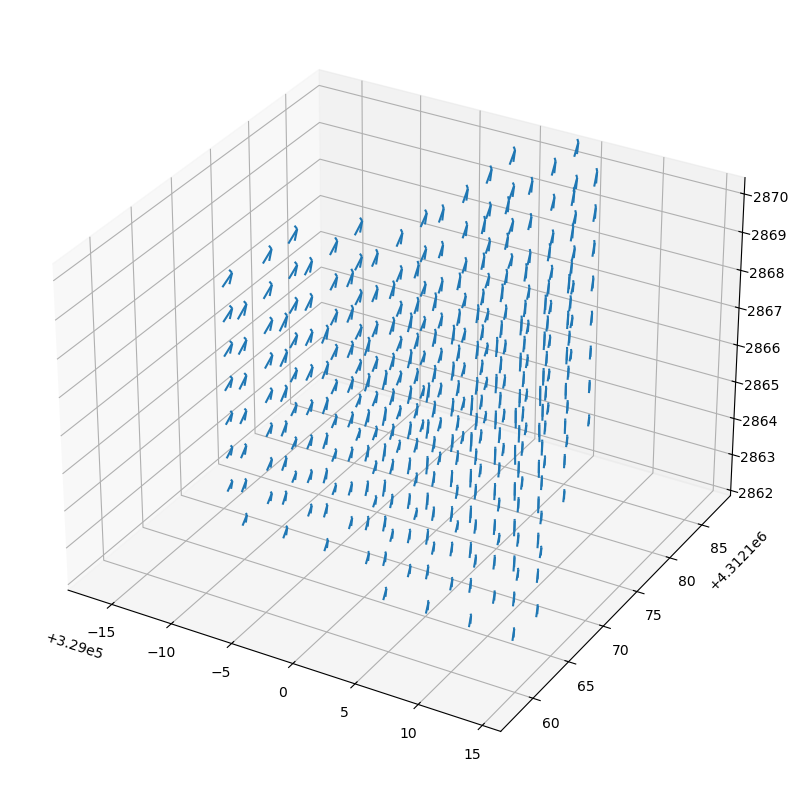

In [34]:
import matplotlib.pyplot as plt
ax = plt.figure(figsize=(10,10)).add_subplot(projection='3d')
ax.quiver(
    xx[::5,::5,::2], 
    yy[::5,::5,::2],
    zz[::5,::5,::2],
    u_interp[100][::5,::5,::2],
    v_interp[100][::5,::5,::2], 
    w_interp[100][::5,::5,::2],
    label='interpolated'
)
# plt.quiver(
#     data_df.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'z')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
#     data_df.iloc[100][(slice(None),slice(None),'w')].values.astype('float'),
#     label='measured',
#     color='red'
# )

## Calculate terms (3D)

Calculate advective terms in both the Paw U form

$u \rho \dfrac{\partial s}{\partial x} + v \rho \dfrac{\partial s}{\partial y} + w \rho \dfrac{\partial s}{\partial z}$

and in the Sun form

$u \dfrac{\partial q}{\partial x} + v \dfrac{\partial q}{\partial y} + w \dfrac{\partial q}{\partial z}$

and also calculate the turbulent flux divergence terms (same for Paw U and Sun)

$\dfrac{\partial \overline{u'q'}}{\partial x} + \dfrac{\partial \overline{v'q'}}{\partial y} + \dfrac{\partial \overline{w'q'}}{\partial z}$

In [35]:
# Create dataframe with grids of interpolated data
u_interp.name = 'u'
v_interp.name = 'v'
w_interp.name = 'w'
u_q__interp.name = 'u_q_'
v_q__interp.name = 'v_q_'
w_q__interp.name = 'w_q_'
rho_interp.name = 'rho'
r_interp.name = 'r'
q_interp.name = 'q'

fields_df = pd.DataFrame(u_interp).join(
    v_interp
).join(
    w_interp
).join(
    u_q__interp
).join(
    v_q__interp
).join(
    w_q__interp
).join(
    rho_interp
).join(
    r_interp
).join(
    q_interp
)

In [36]:
# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
# means of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
# medians of:  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_3d = fields_df.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmean(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y, axis=1)
        ),
        # Vertical advection Paw U style
        np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y, axis=1)
        ),
        # Vertical advection Sun style
        np.nanmedian(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y, axis=1)
        ),
        # Vertical turb. flux divergence
        np.nanmedian(np.gradient(row['w_q_'], spacing_z, axis=2)),
        # Vertical air density flux term (Paw U only)
        ###???
    )
    ,
    axis = 1
)
advective_terms_3d = pd.DataFrame(
    [[a, b, c, d, e, f, g, h, i, j, k, l] for a,b,c,d,e,f,g,h,i,j,k,l in advective_terms_3d.values], 
    columns=['lateral_advection_pawu','vertical_advection_pawu', 'lateral_advection_sun','vertical_advection_sun',
             'lateral_turb_flux_div', 'vertical_turb_flux_div']
)
advective_terms_3d.index = fields_df.index

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:11: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:17: RuntimeWarning: Mean of empty slice
  np.nanmean(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:19: RuntimeWarning: Mean of empty slice
  np.nanmean(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:25: RuntimeWarning: Mean of empty slice
  np.nanmean(row['w']*np.gradient(row['q'], spacing_z, axis=2)),
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:37: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(
/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_24942/4029458110.py:43: RuntimeWarning: All-NaN slice encountered
  np.nanmedian(row['w']*row['rho']*np.gradient(row['r'], spacing_z, axis=2)),
/var/folder

In [ ]:
advective_terms_3d = advective_terms_3d*7
advective_terms_3d

## Examine results

In [ ]:
alt.Chart(
    (advective_terms_3d/7).reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.loc['20230201': '20230205'].reset_index()
).transform_fold(
    list(advective_terms_3d.columns)
).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    # .scale(domain=[0,0.02], clamp=True),
    alt.Color('key:N')
)

# 2D Differential Solution

## 3m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [3]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  means of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
#  medians of: lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_3m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_3m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_3m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_3m.index = fields_df_2d.index

### PLOT: Example of a 2d interpolated wind field

In [ ]:
import matplotlib.pyplot as plt
plt.quiver(
    xx_2d[::4], 
    yy_2d[::4],
    u_interp_2d[100][::4],
    v_interp_2d[100][::4], 
    label='interpolated'
)
plt.quiver(
    data_df_2d.iloc[100][(slice(None),slice(None),'x')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'y')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'u')].values.astype('float'),
    data_df_2d.iloc[100][(slice(None),slice(None),'v')].values.astype('float'),
    label='measured',
    color='red'
)

## 10m height

Repeat all the steps we did above, but just for a single plane at 3m

In [ ]:
HEIGHTS_2D = [10]

# gather all measurements into a dataframe, isolate to the heights we care about
df = wind_field_df.join(
    turb_flux_field_df
).join(
    temp_turb_flux_field_df
).join(
    abs_hum_field_df
).join(
    adv_flux_field_df
).join(
    dryair_density_field_df
).join(
    temp_field_df
).join(
    mixing_ratio_field_df
)
data_df_2d = df[HEIGHTS_2D]

# Gather the instrument locations into a dataframe, isolate to heights we care about
instrument_loc_limited_heights_2d = instrument_loc_df[instrument_loc_df.index.get_level_values(0).isin(HEIGHTS_2D)]

# Transform the dataframe of instrument locations into a form that can be merged with the dataframe of measurements
#   transform
xxx = pd.DataFrame(instrument_loc_limited_heights_2d.unstack().unstack()).T
xxx.columns = xxx.columns.swaplevel(0,2)
xxx.columns = xxx.columns.set_names('measurement', level=2)
#   duplicate the sensor locations so we can join (duplicate) x,y,z info into the dataframe of measurements
instrument_loc_limited_heights_2d_repeated = xxx.loc[xxx.index.repeat(len(data_df_2d))]
instrument_loc_limited_heights_2d_repeated.index = data_df_2d.index
instrument_loc_limited_heights_2d_repeated
data_df_2d = data_df_2d.join(instrument_loc_limited_heights_2d_repeated)
data_df_2d

# Create a meshgrid for the interpolation and isolate the x,y,z locations of measurements
xx_2d, yy_2d = np.meshgrid(
    np.linspace(instrument_loc_limited_heights_2d.x.min(), instrument_loc_limited_heights_2d.x.max(), HORIZ_GRID_SPACING),
    np.linspace(instrument_loc_limited_heights_2d.y.min(), instrument_loc_limited_heights_2d.y.max(), HORIZ_GRID_SPACING)
)
spacing_x_2d = np.diff(xx_2d[0,:]).mean()
spacing_y_2d = np.diff(yy_2d[:,0]).mean()
points_2d = np.transpose(np.vstack((instrument_loc_limited_heights_2d.x, instrument_loc_limited_heights_2d.y)))

# Calculate interpolated fields
    # VECTOR FIELDS
    # wind velocity fields
u_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # turb. flux fields
u_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['u_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
v_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['v_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
w_q__interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['w_h2o_'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
    # SCALAR FIELDS
rho_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['rho'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
r_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['r'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)
q_interp_2d = data_df_2d.loc[:, (slice(None),slice(None),['q'])].apply(
    lambda row:  interpolate.griddata(points_2d, row.values, (xx_2d, yy_2d), method='linear'),
    axis=1
)

# Create dataframe with grids of interpolated data
u_interp_2d.name = 'u'
v_interp_2d.name = 'v'
w_interp_2d.name = 'w'
u_q__interp_2d.name = 'u_q_'
v_q__interp_2d.name = 'v_q_'
w_q__interp_2d.name = 'w_q_'
rho_interp_2d.name = 'rho'
r_interp_2d.name = 'r'
q_interp_2d.name = 'q'

fields_df_2d = pd.DataFrame(u_interp_2d).join(
    v_interp_2d
).join(
    w_interp_2d
).join(
    u_q__interp_2d
).join(
    v_q__interp_2d
).join(
    w_q__interp_2d
).join(
    rho_interp_2d
).join(
    r_interp_2d
).join(
    q_interp_2d
)

# Iterate over the time series of fields and calculate the terms 
# We take the median of the gridded values.
# The apply function returns a tuple of 4 values, with each tuple contains values 
# for the following in order:
#  lateral_advection_pawu , vertical_advection_pawu ,  lateral_advection_sun , vertical_advection_sun, lateral_turb_flux_div, vertical_turb_flux_div 
advective_terms_2d_10m = fields_df_2d.apply(
    lambda row: 
    (
        # Lateral advection Paw U style
        np.nanmean(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmean(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmean(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Paw U style
        np.nanmedian(
            row['u']*row['rho']*np.gradient(row['r'], spacing_x_2d, axis=0)
            +
            row['v']*row['rho']*np.gradient(row['r'], spacing_y_2d, axis=1)
        ),
        # Lateral advection Sun style
        np.nanmedian(
            row['u']*np.gradient(row['q'], spacing_x_2d, axis=0)
            +
            row['v']*np.gradient(row['q'], spacing_y_2d, axis=1)
        ),
        # Lateral turb. flux divergence
        np.nanmedian(
            np.gradient(row['u_q_'], spacing_x_2d, axis=0)
            +
            np.gradient(row['v_q_'], spacing_y_2d, axis=1)
        ),
    ),
    axis = 1
)
advective_terms_2d_10m = pd.DataFrame(
    [[a, b, c, d, e, f] for a, b, c, d, e, f in advective_terms_2d_10m.values], 
    columns=[
        'lateral_advection_pawu (mean)', 
        'lateral_advection_sun (mean)',
        'lateral_turb_flux_div (mean)', 
        'lateral_advection_pawu (median)', 
        'lateral_advection_sun (median)',
        'lateral_turb_flux_div (median)', 
    ]
)
advective_terms_2d_10m.index = fields_df_2d.index

## Average the two planes

In [ ]:
advective_terms_2d_3m

In [ ]:
advective_terms_2d_10m

In [ ]:
advective_terms_2d = (advective_terms_2d_3m + advective_terms_2d_10m)/2
advective_terms_2d = advective_terms_2d*7

## Examine results

In [ ]:
alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_2d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_2d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

In [ ]:
alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' not in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150) | alt.Chart(
    advective_terms_3d.reset_index()
).transform_fold(
    [c for c in list(advective_terms_3d.columns) if 'turb' in c]
).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
).properties(width=200, height = 150)

# Surface Integral Solution

## Define area of triangular prism faces

In [ ]:
from metpy.units import units

In [ ]:
# Define face areas
A1 = A2 = A3 = 37 * 7 * units('m^2')
A4 = A5 = 580.2 * units('m^2')
CV_HEIGHT = 7*units('m')
VOLUME = A4*CV_HEIGHT
A1, A2, A3, A4, A5, VOLUME

## Define normal vectors to the triangular prism faces

In [ ]:
# ELI'S angles
n1 = np.array([ np.cos(np.deg2rad(258.7)),   np.sin(np.deg2rad(258.7))])*units(None)
n2 = np.array([ np.cos(np.deg2rad(20.1)),   np.sin(np.deg2rad(20.1))])*units(None)
n3 = np.array([ np.cos(np.deg2rad(139.26)),   np.sin(np.deg2rad(139.26))])*units(None)

# DANNY'S angles
# n1 = np.array([ np.cos(np.deg2rad(269.5)),   np.sin(np.deg2rad(269.5))])*units(None)
# n2 = np.array([ np.cos(np.deg2rad(19.5)),   np.sin(np.deg2rad(19.5))])*units(None)
# n3 = np.array([ np.cos(np.deg2rad(143.5)),   np.sin(np.deg2rad(143.5))])*units(None)

In [ ]:
import geopandas as gpd
instrument_loc_df = gpd.GeoDataFrame(
    instrument_loc_df,
    geometry = gpd.points_from_xy(
        instrument_loc_df.x, 
        instrument_loc_df.y, 
        instrument_loc_df.z
    ),
    crs = 'EPSG:32613'
)
instrument_loc_df = instrument_loc_df.to_crs('EPSG:4326')
instrument_loc_df

## Calculate storage term

In [ ]:
storage_change_term = tidy_df[
    tidy_df.measurement.isin(['specific humidity', 'air density'])
].query("tower == 'c'").query("height <= 10").query("height >= 3").groupby(
    ['time', 'tower', 'measurement']
)[['value']].mean().reset_index() 
storage_change_term = storage_change_term.pivot_table(index='time', values='value', columns='measurement')

In [ ]:
timestep = storage_change_term.index.diff()[1].seconds * units('seconds')
print(timestep)
absolute_humidity = storage_change_term['specific humidity'].values * units("g/g")  * (
    storage_change_term['air density'].values * units("kg/m^3")
)
delta_humidity = np.diff(absolute_humidity * VOLUME, prepend=np.nan)
dq_dt = delta_humidity / timestep

In [ ]:
storage_change_term['absolute humidity (g/m^3)'] = absolute_humidity.to('g/m^3')
storage_change_term['delta water storage (g/s)'] = dq_dt.to('grams/second')

## Calculate advective flux

In [ ]:
advective_flux_3m_ue = wind_field_df[3]['ue'].multiply(
    abs_hum_field_df[3]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_ue = wind_field_df[10]['ue'].multiply(
    abs_hum_field_df[10]['ue']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_uw = wind_field_df[3]['uw'].multiply(
    abs_hum_field_df[3]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_uw = wind_field_df[10]['uw'].multiply(
    abs_hum_field_df[10]['uw']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_d = wind_field_df[3]['d'].multiply(
    abs_hum_field_df[3]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_d = wind_field_df[10]['d'].multiply(
    abs_hum_field_df[10]['d']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_3m_c = wind_field_df[3]['c'].multiply(
    abs_hum_field_df[3]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

advective_flux_10m_c = wind_field_df[10]['c'].multiply(
    abs_hum_field_df[10]['c']['q'],
    axis=0
).rename(columns={'u': 'uq', 'v': 'vq','w': 'wq',})

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_flux = 0.25*(
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face1_avg_v_flux = 0.25*(
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face2_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_d['uq'] + advective_flux_10m_d['uq']
)

face2_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_d['vq'] + advective_flux_10m_d['vq']
)

face3_avg_u_flux = 0.25*(
    advective_flux_3m_ue['uq'] + advective_flux_10m_ue['uq'] + 
    advective_flux_3m_uw['uq'] + advective_flux_10m_uw['uq']
)

face3_avg_v_flux = 0.25*(
    advective_flux_3m_ue['vq'] + advective_flux_10m_ue['vq'] + 
    advective_flux_3m_uw['vq'] + advective_flux_10m_uw['vq']
)

face4_avg_w_flux = 0.25*(
    advective_flux_10m_ue['wq'] + advective_flux_10m_uw['wq'] + 
    advective_flux_10m_c['wq'] + advective_flux_10m_d['wq']
)

face5_avg_w_flux = - 0.25*(
    advective_flux_3m_ue['wq'] + advective_flux_3m_uw['wq'] + 
    advective_flux_3m_c['wq'] + advective_flux_3m_d['wq']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_flux,
    face1_avg_v_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_flux,
    face2_avg_v_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_flux,
    face3_avg_v_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_adv_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_adv_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_adv_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_adv_divergence = (
    face1_projected_adv_flux*A1.m + 
    face2_projected_adv_flux*A2.m + 
    face3_projected_adv_flux*A3.m
) / VOLUME.m

total_vertical_adv_divergence = (face4_avg_w_flux*A4 + face5_avg_w_flux*A5)  / VOLUME

## Calculate turbulent flux divergence

In [ ]:
# Calculate the average u, v, and w components needed to calculate flux through each face
face1_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face1_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face2_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['d']['u_h2o_'] + turb_flux_field_df[10]['d']['u_h2o_']
)

face2_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['d']['v_h2o_'] + turb_flux_field_df[10]['d']['v_h2o_']
)

face3_avg_u_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['u_h2o_'] + turb_flux_field_df[10]['ue']['u_h2o_'] + 
    turb_flux_field_df[3]['uw']['u_h2o_'] + turb_flux_field_df[10]['uw']['u_h2o_']
)

face3_avg_v_turb_flux = 0.25*(
    turb_flux_field_df[3]['ue']['v_h2o_'] + turb_flux_field_df[10]['ue']['v_h2o_'] + 
    turb_flux_field_df[3]['uw']['v_h2o_'] + turb_flux_field_df[10]['uw']['v_h2o_']
)

face4_avg_w_turb_flux = 0.25*(
    turb_flux_field_df[10]['ue']['w_h2o_'] + turb_flux_field_df[10]['uw']['w_h2o_'] + 
    turb_flux_field_df[10]['c']['w_h2o_'] + turb_flux_field_df[10]['d']['w_h2o_']
)

face5_avg_w_turb_flux = - 0.25*(
    turb_flux_field_df[3]['ue']['w_h2o_'] + turb_flux_field_df[3]['uw']['w_h2o_'] + 
    turb_flux_field_df[3]['c']['w_h2o_'] + turb_flux_field_df[3]['d']['w_h2o_']
)

# Combine the (separate) u and v components into a list of vectors for the lateral faces
face1_avg_adv_flux = np.array([
    face1_avg_u_turb_flux,
    face1_avg_v_turb_flux
]).T

face2_avg_adv_flux = np.array([
    face2_avg_u_turb_flux,
    face2_avg_v_turb_flux
]).T

face3_avg_adv_flux = np.array([
    face3_avg_u_turb_flux,
    face3_avg_v_turb_flux
]).T

# Project the lateral flux vectors onto the face-normal vectors
face1_projected_turb_flux = np.dot(face1_avg_adv_flux, n1.m)
face2_projected_turb_flux = np.dot(face2_avg_adv_flux, n2.m)
face3_projected_turb_flux = np.dot(face3_avg_adv_flux, n3.m)

# Calculate total lateral and vertical flux
total_lateral_turb_divergence = (
    face1_projected_turb_flux*A1.m + 
    face2_projected_turb_flux*A2.m + 
    face3_projected_turb_flux*A3.m
) / VOLUME.m

total_vertical_turb_divergence = (face4_avg_w_turb_flux*A4 + face5_avg_w_turb_flux*A5)  / VOLUME

## Examine results

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_turb_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(w_h2o_):Q')
    )
).properties(title='Vertical Turb. Flux Divergence') | (
    alt.Chart(
        pd.DataFrame(total_lateral_turb_divergence).reset_index().assign(time=total_vertical_turb_divergence.index).rename(columns={0:'u_q_'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(u_q_):Q')
    )
).properties(title='Lateral Turb. Flux Divergence')).resolve_scale(y='shared', x='shared')

In [ ]:
((
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(wq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_vertical_adv_divergence).reset_index()
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(wq):Q')
    )
).properties(title='Vertical Advection') | (
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line().encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('mean(uq):Q')
    )
    +
    alt.Chart(
        pd.DataFrame(total_lateral_adv_divergence).reset_index().assign(time=total_vertical_adv_divergence.index).rename(columns={0:'uq'})
    ).mark_line(color='red').encode(
        alt.X('hoursminutes(time):T'),
        alt.Y('median(uq):Q')
    )
).properties(title='Lateral Advection')).resolve_scale(y='shared', x='shared')

# 1D Differential Solution

## Calculate horizontal advection (using two-point solution to derivative)

### Using KPS and Annex Hygrometer measurements

In [ ]:
# Calculate horizontal advection 
# combine mixing ratio measurements from the two sites into one dataframe 
kpsannex_mixingratio_measurements = mixingratio_ds.sortby('time').sel(
    time=slice('20221101', '20230620')
).resample(time='30min').mean().rename('annex').to_dataframe() / 1000
kps_mixingratio_measurements = abs_hum_field_hygr_df[3]['c']['q_hygr'].rename('kps')
kps_lateral_simple_df = kpsannex_mixingratio_measurements.join(kps_mixingratio_measurements)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_df = kps_lateral_simple_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)
kps_lateral_simple_df = kps_lateral_simple_df[
    ((kps_lateral_simple_df.dir_10m_c >= 100) & (kps_lateral_simple_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_df.dir_10m_c >= 300) & (kps_lateral_simple_df.dir_10m_c <= 340))
]
# label each timestamp up or downvalley
kps_lateral_simple_df['direction'] = kps_lateral_simple_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_df['ds'] = kps_lateral_simple_df.apply(
    lambda row: row['annex'] - row['kps'] if row['direction'] == 'down' else row['kps'] - row['annex'],
    axis=1
)
kps_lateral_simple_df['dx'] = 400
kps_lateral_simple_df['lateral_advection'] = kps_lateral_simple_df['ds'] / kps_lateral_simple_df['dx']

### Using KPS Irga measurements

In [ ]:
# get mixing ratio measurements from the corner towers
upwind_s = 0.5*(mixing_ratio_field_df[3, 'ue', 'r'] + mixing_ratio_field_df[3, 'uw', 'r'])
upwind_s.name = 'upwind_s'
kps_lateral_simple_irga_df = pd.DataFrame(upwind_s)
kps_lateral_simple_irga_df['downwind_s'] = mixing_ratio_field_df[3, 'd', 'r']


# # Add wind dir variable
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'dir_10m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('dir_10m_c')
)

# isolate measurements to when wind is up (100˚ - 140˚) or downvalley (300 - 340)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df[
    ((kps_lateral_simple_irga_df.dir_10m_c >= 100) & (kps_lateral_simple_irga_df.dir_10m_c <= 140))
    |
    ((kps_lateral_simple_irga_df.dir_10m_c >= 300) & (kps_lateral_simple_irga_df.dir_10m_c <= 340))
]

# label each timestamp up or downvalley
kps_lateral_simple_irga_df['direction'] = kps_lateral_simple_irga_df['dir_10m_c'].apply(lambda x: 'down' if 300 <= x <= 340 else 'up')
# # Calculate deltas. During downvalley winds, ds = annex - kps. During up valley winds, ds = kps - annex
kps_lateral_simple_irga_df['ds'] = kps_lateral_simple_irga_df.apply(
    lambda row: row['downwind_s'] - row['upwind_s'] if row['direction'] == 'down' else row['upwind_s'] - row['downwind_s'],
    axis=1
)

kps_lateral_simple_irga_df['dx'] = 32
kps_lateral_simple_irga_df['ds/dx'] = kps_lateral_simple_irga_df['ds'] / kps_lateral_simple_irga_df['dx']
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'u_3m_c'").set_index('time')['value'].rename('u')
)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    1000*tidy_df.query("variable == 'dryairdensity_3m_c'").set_index('time')['value'].rename('rho')
)
kps_lateral_simple_irga_df = kps_lateral_simple_irga_df.join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time')['value'].rename('w_h2o__3m_c')
)
kps_lateral_simple_irga_df['lateral_advection_irga'] = kps_lateral_simple_irga_df['u'] * kps_lateral_simple_irga_df['rho'] * kps_lateral_simple_irga_df['ds/dx']
kps_lateral_simple_irga_df

## Calculate vertical advection

### Simple two-point solution to the derivative

In [ ]:
kps_mixingratio_measurements_3m = tidy_df.query("variable == 'mixingratio_3m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_3m_c')
kps_mixingratio_measurements_10m = tidy_df.query("variable == 'mixingratio_10m_c'").set_index('time').loc[
    '20221101': '20230620'
]['value'].rename('mixingratio_10m_c')
kps_vert_simple_df = pd.DataFrame(kps_mixingratio_measurements_3m).join(kps_mixingratio_measurements_10m)
kps_vert_simple_df['ds'] = kps_vert_simple_df['mixingratio_10m_c'] - kps_vert_simple_df['mixingratio_3m_c']
kps_vert_simple_df['dz'] = 7
kps_vert_simple_df['ds/dz'] = kps_vert_simple_df['ds'] / kps_vert_simple_df['dz']

kps_vert_simple_df = kps_vert_simple_df.join(
    tidy_df.query("variable == 'w_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w')
).join(
    1000*tidy_df.query("variable == 'dryairdensity_5m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('rho')
).join(
    tidy_df.query("variable == 'w_h2o__3m_c'").set_index('time').loc['20221101': '20230620']['value'].rename('w_h2o__3m_c')
)
kps_vert_simple_df['vertical_advection_simple'] =  kps_vert_simple_df['w'] * kps_vert_simple_df['rho'] * kps_vert_simple_df['ds/dz']

### Numerical multi-point solution to the derivative

In [ ]:
# gather the measurements we want
kps_mixingratio_measurements = tidy_df[tidy_df.measurement == 'mixing ratio'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_dryairdensity_measurements = tidy_df[tidy_df.measurement == 'dry air density'][tidy_df.height >= 3][tidy_df.height <= 10]
kps_verticalvelocity_measurements = tidy_df[tidy_df.measurement == 'w'].query("tower == 'c'")

# iterate over each timestamp, doing calculations for each
timestamps = kps_mixingratio_measurements.time.unique()
vert_adv_ls = []
ts_ls = []
for ts in timestamps:
    # get the measurements we want for this timestamp 
    ex_s = kps_mixingratio_measurements[kps_mixingratio_measurements.time == ts]
    ex_rho = kps_dryairdensity_measurements[kps_dryairdensity_measurements.time == ts]
    ex_w = kps_verticalvelocity_measurements[kps_verticalvelocity_measurements.time == ts]
    # calculate the scalar gradient profile
    ds_dz = np.gradient(
        ex_s.sort_values('height')['value'],
        ex_s.sort_values('height')['height'],
    )
    # calculate the wind profile by interpolating actual measurements to where we have mixing ratio measurements
    w_interp = np.interp(
        ex_s.sort_values('height')['height'],
        ex_w.sort_values('height')['height'],
        ex_w.sort_values('height')['value']
    )
    # Calculate the vertical advection term
    vert_advection = (1000 * ex_rho.sort_values('height').value.values * w_interp * ds_dz).sum()
    vert_adv_ls.append(vert_advection)
    ts_ls.append(ts)

kps_vert_complex_df = pd.DataFrame({
    'time': ts_ls,
    'vertical_advection_complex': vert_adv_ls
})

In [ ]:
advection_1d_df = kps_vert_simple_df[['vertical_advection_simple']].join(
    kps_vert_complex_df.set_index('time')[['vertical_advection_complex']]
).join(
    kps_lateral_simple_df[['lateral_advection']]
).join(
    kps_lateral_simple_irga_df['lateral_advection_irga']
)

## Examine results

In [ ]:
alt.Chart(
    advection_1d_df.reset_index()
).transform_fold([
    'vertical_advection_simple',
    'lateral_advection',
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)

In [ ]:
alt.Chart(
    advection_1d_df.reset_index()
).transform_fold([
    'vertical_advection_simple',
    'vertical_advection_complex',
    'lateral_advection',
    'lateral_advection_irga'
]).mark_line().encode(
    alt.X('hoursminutes(time):T'),
    alt.Y('median(value):Q'),
    alt.Color('key:N')
)